## Importing Libraries

In [1]:
!pip install neattext

     |████████████████████████████████| 114 kB 26.1 MB/s            


In [2]:
!pip install scikit-multilearn 

     |████████████████████████████████| 89 kB 1.2 MB/s             


In [3]:
!pip install xgboost

     |████████████████████████████████| 173.6 MB 6.5 kB/s              


In [4]:
import pandas as pd 
import numpy as np 
import re
import string

In [5]:
# text processing libraries
import re
import string
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer



In [6]:
# plot libraries
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 
sns.set(color_codes=True)

In [126]:
# model related libraries
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

from skmultilearn.adapt import MLkNN
# from sklearn.model_selection import train_test_split

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
# import xgboost as xgb

In [51]:
# metrics
from sklearn.metrics import classification_report, multilabel_confusion_matrix, recall_score, roc_auc_score
from sklearn.metrics import accuracy_score, hamming_loss

In [10]:
# others
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Data Exploration

First let's look at how the data is organized. 

In [11]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test_labels = pd.read_csv('data/test_labels.csv')

#### Then lets make some visualization about the dataset for furhter understanding.

Strating from a simple bar chart that shows the number of comments for each category. 

Text(0.5, 0, '# of categories')

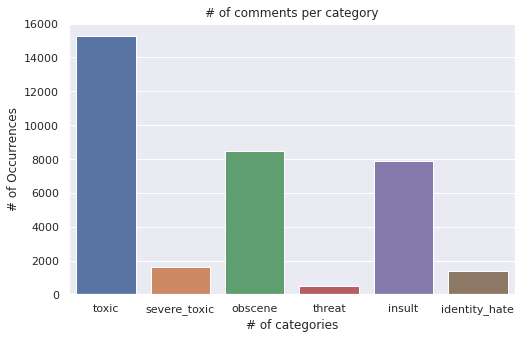

In [12]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 
      'insult', 'identity_hate']
labels_data = train[labels]
label_count = labels_data.sum()
plt.figure(figsize=(8,5))
ax = sns.barplot(label_count.index, label_count.values)
plt.title("# of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [13]:
# test_data = pd.read_csv('data/test.csv')
# test_labels = pd.read_csv('data/test_labels.csv')

Since the categories are not mutally exclusive, let's see how many categories each comment coantains. 

Text(0.5, 0, '# of categories')

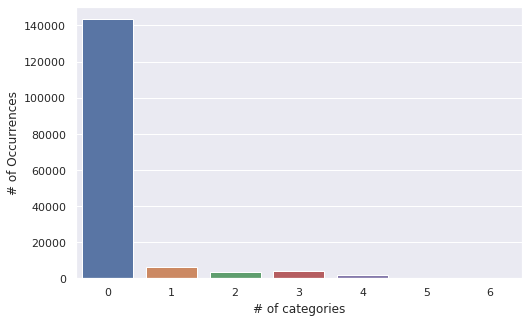

In [14]:
rowsums = train.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

We can see that the dataset is biased towards non-categoized comments. 



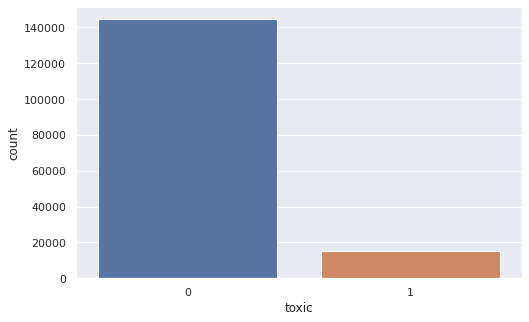

In [15]:
plt.figure(figsize=(8,5))
g = sns.countplot(train['toxic'])
plt.show()

In [183]:
def plot_data(train): 
    barWidth = 0.35
    plt.figure(figsize=(9,7))
    bars1 = [sum(train['toxic'] == 1), sum(train['severe_toxic'] == 1), sum(train['obscene'] == 1), sum(train['threat'] == 1),
             sum(train['insult'] == 1), sum(train['identity_hate'] == 1)]
    bars2 = [sum(train['toxic'] == 0), sum(train['severe_toxic'] == 0), sum(train['obscene'] == 0), sum(train['threat'] == 0),
             sum(train['insult'] == 0), sum(train['identity_hate'] == 0)]

    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]

    plt.bar(r1, bars1, color='steelblue', width=barWidth, label='classified')
    plt.bar(r2, bars2, color='lightsteelblue', width=barWidth, label='not_classified')

    plt.xlabel('categories')
    plt.ylabel('# of comments')
    plt.xticks([r + barWidth for r in range(len(bars1))], labels)

    plt.legend()
    plt.show()
    pass 

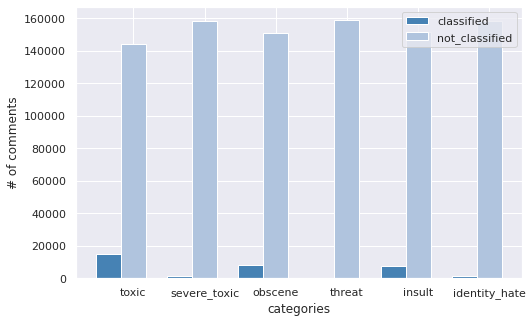

In [79]:
plot_data(train)

The plot above shows that there is an imbalance dataset. So, to address this issue we will need to drop data that does not fall into any category

In [18]:
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [19]:
test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [20]:
test_labels

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


We can see that the testing set is devided into two sets, one conatins the comments ` X ` and the other contains the labels ` y `. Where they are linked via the comment id number. 

We can also notice that some comments conatain label values of  ` -1 `, which according to the dataset source indicates an ingonre signal that does not mean anything. 
So we will drop rows that conatians -1 labels in both data and data_labels sets. 

In [21]:
# Dropping data with labels values of -1 
drop_index = test_labels[
    (test_labels['toxic'] == -1) | 
    (test_labels['severe_toxic'] == -1) | 
    (test_labels['obscene'] == -1) | 
    (test_labels['threat'] == -1) | 
    (test_labels['insult'] == -1) | 
    (test_labels['identity_hate'] == -1)
]['id']
test = test[~test.id.isin(drop_index)]
test_labels = test_labels[~test_labels.id.isin(drop_index)]

In [22]:
# # train = pd.read_csv('data/train-processed.csv')
# # train.drop('id', axis=1, inplace=True)
# data_drop = train[
#     (train['toxic'] == 0) & 
#     (train['severe_toxic'] == 0) & 
#     (train['obscene'] == 0) & 
#     (train['threat'] == 0) & 
#     (train['insult'] == 0) & 
#     (train['identity_hate'] == 0)
#          ].sample(frac=1).head(int(len(train)*(55/100)))

# train.drop(data_drop.index, axis=0, inplace=True)
# train.reset_index(drop=True, inplace=True)

## 2. Data Preparation


### Data Preprocessing

For data cleaning we need to define a function to: 
  * `Remove HTML tags`
  * `Convert all letters into lowerecase`
  * `Remove all non-alphapet characters`

In [23]:
# import neattext.functions as nfx
import re
from bs4 import BeautifulSoup
# from nltk.stem.porter import *
from nltk.stem import SnowballStemmer
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(data):
    stemmer = SnowballStemmer(language='english')
    text = BeautifulSoup(data, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z]", " ", text.lower()) # Convert to lower case
    words = text.split()
    words = [stemmer.stem(w) for w in words if w not in stopwords.words("english")] # Remove stopwords
#     words = [stemmer.stem(w) for w in words] # stem
    words = ' '.join(words)

    return words

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


First, let's take a look at a sample origianl comment.

In [24]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

Then let's see the same comment after cleaning. 

In [25]:
preprocess_text(train['comment_text'][0])

'explan edit made usernam hardcor metallica fan revert vandal closur gas vote new york doll fac pleas remov templat talk page sinc retir'

#### Processing all comments in the training and testing sets. 

In [26]:
train['comment_text'] = train['comment_text'].apply(preprocess_text)
test['comment_text'] = test['comment_text'].apply(preprocess_text)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/bs4/__init__.py:424: MarkupResemblesLocatorWarning: "http://en.wikipedia.org/wiki/Wikipedia_talk:No_original_research/archive15#YouTube_art_as_primary_source" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/bs4/__init__.py:424: MarkupResemblesLocatorWarning: "http://finance.yahoo.com/news/7-fascinating-nuggets-another-bewildering-150348488.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/bs4/__init__.py:424: MarkupResemblesLocatorWarning: "http:

In [27]:
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explan edit made usernam hardcor metallica fan...,0,0,0,0,0,0
1,000103f0d9cfb60f,aww match background colour seem stuck thank t...,0,0,0,0,0,0
2,000113f07ec002fd,hey man realli tri edit war guy constant remov...,0,0,0,0,0,0
3,0001b41b1c6bb37e,make real suggest improv wonder section statis...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chanc rememb page,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,second time ask view complet contradict covera...,0,0,0,0,0,0
159567,ffea4adeee384e90,asham horribl thing put talk page,0,0,0,0,0,0
159568,ffee36eab5c267c9,spitzer umm there actual articl prostitut ring...,0,0,0,0,0,0
159569,fff125370e4aaaf3,look like actual put speedi first version dele...,0,0,0,0,0,0


In [28]:
test

,id,comment_text
5,0001ea8717f6de06,thank understand think high would revert witho...
7,000247e83dcc1211,dear god site horribl
11,0002f87b16116a7f,somebodi invari tri add religion realli mean w...
13,0003e1cccfd5a40a,say right type type institut need case three l...
14,00059ace3e3e9a53,ad new product list make sure relev ad new pro...
...,...,...
153150,fff8f64043129fa2,jerom see never got around surpris look exampl...
153151,fff9d70fe0722906,lucki bastard http wikimediafound org wiki pre...
153154,fffa8a11c4378854,shame want speak gay romanian
153155,fffac2a094c8e0e2,mel gibson nazi bitch make shitti movi much bu...


#### Spliting training and testing sets

In [140]:
X_train = train['comment_text']
y_train = train[labels]

X_test = test['comment_text']
y_test = test_labels[labels]

## 3. Modeling

Since we have a huge set of data, and extracting text_features using TfidfVectorizer that will be fed to the model will require a huge amount of memory.

We will use sklearn's `Pipline` to extract features from comments and train the model through piplining over each row, to save space. 

To do that we will define a function that will generate a pipline with the same vectorizer properties for differernt classifiers. 

### I. Initial Stage: Benchmarking

In [137]:
def define_model(Classifier):
    model = Pipeline([
                    ('tfidf', TfidfVectorizer(
                        strip_accents='unicode',     
                        analyzer='word',            
                        token_pattern=r'\w{1,}',    
                        ngram_range=(1, 3),         
                        stop_words='english',
                        sublinear_tf=True)
                    ),
                    ('clf', Classifier)
                ])
    return model
    pass

In [31]:
# labels= ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# train = pd.read_csv('model_data/train-processed.csv')
# test = pd.read_csv('model_data/test-processed.csv')
# test_labels = pd.read_csv('model_data/test_labels-processed.csv')

In [32]:
def train_and_test(x_train, y_train, x_test, y_test, model, labels):
#     predecition_df = pd.DataFrame()
#     for category in labels:
#         print('... Processing {}'.format(category))
#         # train the model using X_dtm & y
#         model.fit(x_train, y_train[category])
#         # compute the testing accuracy
#         prediction = model.predict(x_test)
# #         print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
# #         print('Test accuracy is {}'.format(hamming_loss(y_test[category], prediction)))
#         predecition_df[category] = prediction
    model.fit(x_train, y_train)
    prediction = model.predict(x_test)
    return prediction
    pass



#### We will use `OneVsRestClassifier` for each of the following models


#### MultinomialNB

In [33]:
model = define_model(OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None)))
MNB_pred = train_and_test(X_train, y_train, X_test, y_test, model, labels)

In [34]:
print(classification_report(
    y_test,
    MNB_pred,
    output_dict=False,
    target_names=labels
))

               precision    recall  f1-score   support

        toxic       0.97      0.07      0.14      6090
 severe_toxic       0.00      0.00      0.00       367
      obscene       0.99      0.04      0.08      3691
       threat       0.00      0.00      0.00       211
       insult       1.00      0.00      0.01      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.98      0.04      0.08     14498
    macro avg       0.49      0.02      0.04     14498
 weighted avg       0.90      0.04      0.08     14498
  samples avg       0.01      0.00      0.00     14498



/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, l

In [144]:
multilabel_confusion_matrix(y_test, MNB_pred)

array([[[57876,    12],
        [ 5634,   456]],

       [[63611,     0],
        [  367,     0]],

       [[60285,     2],
        [ 3544,   147]],

       [[63767,     0],
        [  211,     0]],

       [[60551,     0],
        [ 3412,    15]],

       [[63266,     0],
        [  712,     0]]])


#### `we can see from the confusion_matrix that MultinomialNB did not did not predict the postitive values for severe_toxic, threat, and identity_hate.`

### LogisticRegression

In [35]:
model = define_model(OneVsRestClassifier(LogisticRegression(C = 10, penalty='l2', solver = 'liblinear', random_state=100)))
LR_pred = train_and_test(X_train, y_train, X_test, y_test, model, labels)

In [36]:
print(classification_report(
    y_test,
    LR_pred,
    output_dict=False,
    target_names=labels
))

               precision    recall  f1-score   support

        toxic       0.56      0.83      0.67      6090
 severe_toxic       0.27      0.51      0.35       367
      obscene       0.62      0.77      0.69      3691
       threat       0.41      0.36      0.38       211
       insult       0.58      0.72      0.64      3427
identity_hate       0.55      0.53      0.54       712

    micro avg       0.56      0.76      0.65     14498
    macro avg       0.50      0.62      0.55     14498
 weighted avg       0.57      0.76      0.65     14498
  samples avg       0.07      0.07      0.07     14498



/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### LinearSVC

In [37]:
model = define_model(OneVsRestClassifier(LinearSVC(), n_jobs=4))
OSVC_pred = train_and_test(X_train, y_train, X_test, y_test, model, labels)

In [38]:
print(classification_report(
    y_test,
    OSVC_pred,
    output_dict=False,
    target_names=labels
))

               precision    recall  f1-score   support

        toxic       0.55      0.85      0.67      6090
 severe_toxic       0.33      0.38      0.35       367
      obscene       0.60      0.77      0.67      3691
       threat       0.44      0.18      0.26       211
       insult       0.58      0.71      0.64      3427
identity_hate       0.66      0.42      0.51       712

    micro avg       0.57      0.75      0.65     14498
    macro avg       0.53      0.55      0.52     14498
 weighted avg       0.57      0.75      0.64     14498
  samples avg       0.07      0.07      0.07     14498



/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### XGBoost

In [40]:
# model = define_model(OneVsRestClassifier(xgb.XGBClassifier()))
# xgb_pred = train_and_test(X_train, y_train, X_test, y_test, model, labels)
# print(classification_report(
#     y_test,
#     xgb_pred,
#     output_dict=False,
#     target_names=labels
# ))

###  II. Refinement stage

In this stage we will try to tune the models.  


Tuninig will be done by modifing different paramater for the vectorizer to enhance feature extraction.

To do that we will rewrite `define_model` method with more parameters. 

In [145]:
def define_model(Classifier, max_df, ngram, max_features):
    model = Pipeline([
                    ('tfidf', TfidfVectorizer(
                        max_df=max_df,
                        strip_accents='unicode',     
                        analyzer='word',            
                        token_pattern=r'\w{1,}',    
                        ngram_range=(1, ngram),         
                        stop_words='english',
                        sublinear_tf=True,
                        max_features=max_features)
                     ),
                    ('clf', Classifier)
                ])
    return model
    pass

Lets start with Logistic Regression

In [50]:
model = define_model(OneVsRestClassifier(LogisticRegression(C = 10, penalty='l2', solver = 'liblinear', random_state=100)), 0.25, 2, None)
pred = train_and_test(X_train, y_train, X_test, y_test, model, labels)
print(classification_report(
    y_test,
    pred,
    output_dict=False,
    target_names=labels
))

               precision    recall  f1-score   support

        toxic       0.58      0.81      0.68      6090
 severe_toxic       0.32      0.42      0.37       367
      obscene       0.65      0.74      0.69      3691
       threat       0.41      0.30      0.35       211
       insult       0.62      0.65      0.64      3427
identity_hate       0.61      0.46      0.53       712

    micro avg       0.60      0.72      0.65     14498
    macro avg       0.53      0.56      0.54     14498
 weighted avg       0.60      0.72      0.65     14498
  samples avg       0.07      0.07      0.07     14498



/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We can see that the precision has increased 

Let's increase n_gram to 4

In [148]:
model = define_model(OneVsRestClassifier(LogisticRegression(C = 10, penalty='l2', solver = 'liblinear', random_state=100)), 0.25, 4, None)
pred = train_and_test(X_train, y_train, X_test, y_test, model, labels)
print(classification_report(
    y_test,
    pred,
    output_dict=False,
    target_names=labels
))

               precision    recall  f1-score   support

        toxic       0.86      0.88      0.87      6090
 severe_toxic       0.28      0.51      0.36       367
      obscene       0.77      0.79      0.78      3691
       threat       0.51      0.39      0.44       211
       insult       0.70      0.75      0.72      3427
identity_hate       0.67      0.55      0.60       712

    micro avg       0.76      0.79      0.78     14498
    macro avg       0.63      0.64      0.63     14498
 weighted avg       0.77      0.79      0.78     14498
  samples avg       0.32      0.34      0.31     14498



/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
model = define_model(OneVsRestClassifier(LinearSVC()), 0.3, 5, None)
pred = train_and_test(X_train, y_train, X_test, y_test, model, labels)
print(classification_report(
    y_test,
    pred,
    output_dict=False,
    target_names=labels
))

               precision    recall  f1-score   support

        toxic       0.53      0.86      0.66      6090
 severe_toxic       0.31      0.39      0.35       367
      obscene       0.57      0.78      0.66      3691
       threat       0.43      0.16      0.23       211
       insult       0.56      0.73      0.63      3427
identity_hate       0.63      0.42      0.50       712

    micro avg       0.55      0.77      0.64     14498
    macro avg       0.51      0.56      0.51     14498
 weighted avg       0.55      0.77      0.63     14498
  samples avg       0.07      0.07      0.07     14498



/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
model = define_model(OneVsRestClassifier(LinearSVC()), 0.25, 5, None)
pred = train_and_test(X_train, y_train, X_test, y_test, model, labels)
print(classification_report(
    y_test,
    pred,
    output_dict=False,
    target_names=labels
))

               precision    recall  f1-score   support

        toxic       0.53      0.86      0.66      6090
 severe_toxic       0.31      0.39      0.35       367
      obscene       0.57      0.78      0.66      3691
       threat       0.43      0.16      0.23       211
       insult       0.56      0.73      0.63      3427
identity_hate       0.63      0.42      0.50       712

    micro avg       0.55      0.77      0.64     14498
    macro avg       0.51      0.56      0.51     14498
 weighted avg       0.55      0.77      0.63     14498
  samples avg       0.07      0.07      0.07     14498



/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Now we will use only a subset of the dataset. 
Some of the uncategorized entries will be dropped to recude the imbalance.

Let's start by dropping 50% of the uncategorized data. 

In [195]:
drop_index = train[
    (train['toxic'] == 0) & 
    (train['severe_toxic'] == 0) & 
    (train['obscene'] == 0) & 
    (train['threat'] == 0) & 
    (train['insult'] == 0) & 
    (train['identity_hate'] == 0)
           ].sample(frac=1).head(int(len(train)*(67/100))).index
train_copy = train[~train.index.isin(drop_index)]
train_copy

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,00025465d4725e87,congratul well use tool well talk,0,0,0,0,0,0
6,0002bcb3da6cb337,cocksuck piss around work,1,1,1,0,1,0
12,0005c987bdfc9d4b,hey talk exclus group wp taliban good destroy ...,1,0,0,0,0,0
16,0007e25b2121310b,bye look come think com back tosser,1,0,0,0,0,0
18,0009801bd85e5806,mitsurugi point made sens argu includ hindi ry...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159550,ffba5332d6b8fd14,agre anoth note lil wayn talentless man tupac ...,0,0,0,0,0,0
159554,ffbdbb0483ed0841,go keep post stuff u delet fuck site close fun...,1,0,1,0,1,0
159563,ffe029a7c79dc7fe,pleas identifi part blp appli blp clear state ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,spitzer umm there actual articl prostitut ring...,0,0,0,0,0,0


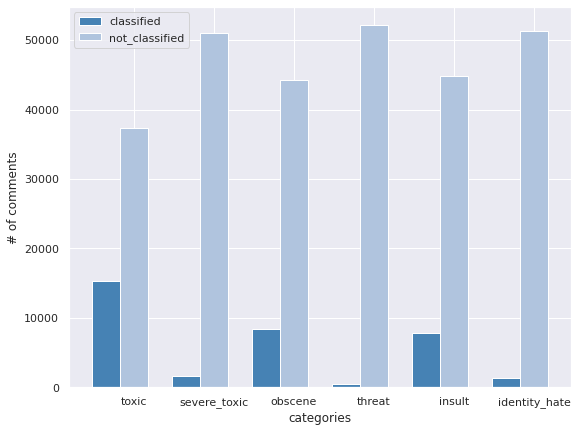

In [196]:
plot_data(train_copy)

In [191]:
drop_index = test_labels[
    (test_labels['toxic'] == 0) & 
    (test_labels['severe_toxic'] == 0) & 
    (test_labels['obscene'] == 0) & 
    (test_labels['threat'] == 0) & 
    (test_labels['insult'] == 0) & 
    (test_labels['identity_hate'] == 0)
           ].sample(frac=1).head(int(len(train)*(33/100))).id
test_copy = test[~test.id.isin(drop_index)]
test_labels_copy = test_labels[~test_labels.id.isin(drop_index)].reset_index()
test_labels_copy

,index,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,7,000247e83dcc1211,0,0,0,0,0,0
1,21,00091c35fa9d0465,1,0,0,0,0,0
2,43,0012bb72f20ae971,0,0,0,0,0,0
3,48,0013fed3aeae76b7,1,0,1,0,1,1
4,58,00177176f33f587e,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
11315,153078,ffdf6854b41d9102,1,0,0,0,0,0
11316,153100,ffe5685dbc45e616,0,0,0,0,0,0
11317,153119,ffebe90c8d5acaba,1,0,1,0,0,0
11318,153147,fff83b80284d8440,0,0,0,0,0,0


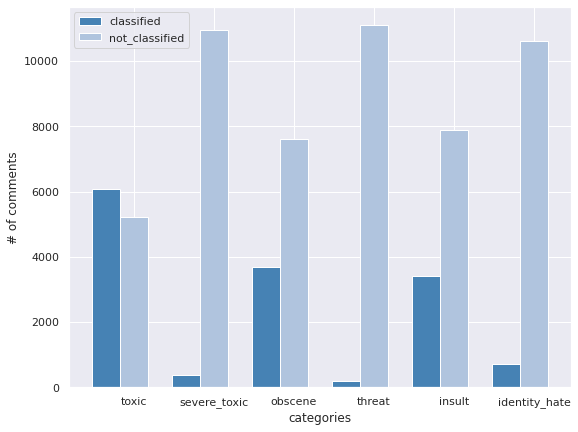

In [190]:
plot_data(test_labels_copy)

In [197]:
X_train = train_copy['comment_text']
y_train = train_copy[labels]

X_test = test_copy['comment_text']
y_test = test_labels_copy[labels]

In [198]:
%%time

model = define_model(OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None)), 0.25, 2, None)
pred = train_and_test(X_train, y_train, X_test, y_test, model, labels)
print(classification_report(
    y_test,
    pred,
    output_dict=False,
    target_names=labels
))

               precision    recall  f1-score   support

        toxic       0.97      0.40      0.57      6090
 severe_toxic       0.00      0.00      0.00       367
      obscene       0.97      0.15      0.27      3691
       threat       0.00      0.00      0.00       211
       insult       0.93      0.07      0.13      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.97      0.23      0.37     14498
    macro avg       0.48      0.10      0.16     14498
 weighted avg       0.88      0.23      0.34     14498
  samples avg       0.22      0.11      0.14     14498

CPU times: user 7.12 s, sys: 52.6 ms, total: 7.17 s
Wall time: 7.17 s


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, l

In [199]:
%%time

model = define_model(OneVsRestClassifier(LinearSVC()), 0.25, 2, None)
pred = train_and_test(X_train, y_train, X_test, y_test, model, labels)
print(classification_report(
    y_test,
    pred,
    output_dict=False,
    target_names=labels
))

               precision    recall  f1-score   support

        toxic       0.89      0.90      0.89      6090
 severe_toxic       0.37      0.35      0.36       367
      obscene       0.81      0.77      0.79      3691
       threat       0.53      0.25      0.34       211
       insult       0.74      0.69      0.71      3427
identity_hate       0.80      0.46      0.59       712

    micro avg       0.81      0.77      0.79     14498
    macro avg       0.69      0.57      0.61     14498
 weighted avg       0.81      0.77      0.79     14498
  samples avg       0.44      0.43      0.42     14498

CPU times: user 8.75 s, sys: 82.9 ms, total: 8.83 s
Wall time: 8.83 s


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [200]:
# logistic Regresssion 

model = define_model(OneVsRestClassifier(LogisticRegression()), 0.25, 2, None)
pred = train_and_test(X_train, y_train, X_test, y_test, model, labels)
print(classification_report(
    y_test,
    pred,
    output_dict=False,
    target_names=labels
))

               precision    recall  f1-score   support

        toxic       0.91      0.83      0.87      6090
 severe_toxic       0.31      0.29      0.30       367
      obscene       0.86      0.69      0.76      3691
       threat       0.49      0.10      0.17       211
       insult       0.76      0.62      0.69      3427
identity_hate       0.83      0.31      0.45       712

    micro avg       0.84      0.70      0.76     14498
    macro avg       0.69      0.47      0.54     14498
 weighted avg       0.84      0.70      0.75     14498
  samples avg       0.41      0.38      0.38     14498



/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [201]:
%%time
# Linear SVC with random_state=42 


model = define_model(OneVsRestClassifier(LinearSVC(random_state=42)), 0.25, 2, None)
pred = train_and_test(X_train, y_train, X_test, y_test, model, labels)
print(classification_report(
    y_test,
    pred,
    output_dict=False,
    target_names=labels
))


               precision    recall  f1-score   support

        toxic       0.89      0.90      0.89      6090
 severe_toxic       0.37      0.35      0.36       367
      obscene       0.81      0.77      0.79      3691
       threat       0.53      0.25      0.34       211
       insult       0.74      0.69      0.71      3427
identity_hate       0.80      0.46      0.59       712

    micro avg       0.81      0.77      0.79     14498
    macro avg       0.69      0.57      0.61     14498
 weighted avg       0.81      0.77      0.79     14498
  samples avg       0.44      0.43      0.42     14498

CPU times: user 8.53 s, sys: 20.6 ms, total: 8.56 s
Wall time: 8.55 s


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [203]:
%%time
# Linear SVC with random_state=42 


model = define_model(OneVsRestClassifier(LinearSVC(random_state=42)), 0.25, 2, 50000)
pred = train_and_test(X_train, y_train, X_test, y_test, model, labels)
print(classification_report(
    y_test,
    pred,
    output_dict=False,
    target_names=labels
))

               precision    recall  f1-score   support

        toxic       0.89      0.87      0.88      6090
 severe_toxic       0.38      0.33      0.35       367
      obscene       0.83      0.73      0.77      3691
       threat       0.56      0.30      0.39       211
       insult       0.75      0.62      0.68      3427
identity_hate       0.81      0.42      0.56       712

    micro avg       0.83      0.73      0.78     14498
    macro avg       0.70      0.54      0.61     14498
 weighted avg       0.82      0.73      0.77     14498
  samples avg       0.43      0.40      0.40     14498

CPU times: user 7.36 s, sys: 5.83 ms, total: 7.37 s
Wall time: 7.37 s


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [206]:
%%time
# Deceision Tree

model = define_model(OneVsRestClassifier(LinearSVC(random_state=42)), 0.5, 4, None)
pred = train_and_test(X_train, y_train, X_test, y_test, model, labels)
print(classification_report(
    y_test,
    pred,
    output_dict=False,
    target_names=labels
))

               precision    recall  f1-score   support

        toxic       0.88      0.91      0.90      6090
 severe_toxic       0.33      0.38      0.35       367
      obscene       0.78      0.80      0.79      3691
       threat       0.51      0.23      0.32       211
       insult       0.71      0.75      0.73      3427
identity_hate       0.78      0.48      0.59       712

    micro avg       0.79      0.80      0.79     14498
    macro avg       0.66      0.59      0.61     14498
 weighted avg       0.79      0.80      0.79     14498
  samples avg       0.43      0.44      0.42     14498

CPU times: user 26.7 s, sys: 806 ms, total: 27.5 s
Wall time: 27.5 s


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [207]:
model = define_model(OneVsRestClassifier(LogisticRegression()), 0.25, 4, None)
pred = train_and_test(X_train, y_train, X_test, y_test, model, labels)
print(classification_report(
    y_test,
    pred,
    output_dict=False,
    target_names=labels
))

               precision    recall  f1-score   support

        toxic       0.91      0.83      0.87      6090
 severe_toxic       0.29      0.37      0.33       367
      obscene       0.84      0.71      0.77      3691
       threat       0.53      0.09      0.15       211
       insult       0.74      0.67      0.70      3427
identity_hate       0.82      0.32      0.46       712

    micro avg       0.82      0.71      0.76     14498
    macro avg       0.69      0.50      0.55     14498
 weighted avg       0.82      0.71      0.76     14498
  samples avg       0.40      0.38      0.37     14498



/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4. Conclusion

The best model obtained is: 
